In [1]:
import os
from utils import *
import joblib
os.listdir('../model')

['Critic.pkl', 'PAagent.pkl']

In [2]:
agent = joblib.load('../model/PAagent.pkl')

In [3]:
set_state = 0.75
set_request = 8000

In [4]:
state = set_state
request = set_request
advice,output,stream = agent.get_advice(state,request)
print('state',state)
print('request',request)
print('output',output[0][0])
print('stream',stream[0][0])
advice[:-1]

state 0.75
request 8000
output 7498.9556
stream 15294.286


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,6724.221191,6724.701660,6723.586914
MLPAP_TJC-0627.PV,OX預熱器出口溫度,145.458115,145.459503,145.457306
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,160.496719,160.496964,160.496597
MLPAP_FR-0632.PV,汽機風量,84.383179,84.383507,84.382805
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,351.415955,351.417908,351.414398
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,49.678707,49.678715,49.678696
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,62.161663,62.163734,62.161072
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,191.719604,191.721664,191.715851
MLPAP_TRC-0747.PV,E220出口溫度,107.690735,107.695038,107.689735
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,347.227844,347.228943,347.227173


# compare with real data

In [5]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag_dict = dict(zip(tag.TAG,tag.chinese))
data = joblib.load('../data/dataset.pkl')
data.keys()

#load real data
state = data['mm_state'].inverse_transform(data['state'])
action = [data['mm_action'].inverse_transform(i) for i in data['action']]
output = data['mm_output'].inverse_transform(data['output'])
stream = data['mm_stream'].inverse_transform(data['stream'])

#calculate distance
distance_state = (state - set_state)**2
distance_output = (output - set_request)**2
min_distance_idx =  np.argmin(distance_state + distance_output)
min_distance_idx

# show result
real_output = output[min_distance_idx][0]
real_state = state[min_distance_idx][0]
print('state',real_state)
print('output',real_output)

real = pd.DataFrame(action[min_distance_idx],columns=data['action_col'])
real.loc['mean'] = real.mean(axis=0)
real.loc['max'] = real.max(axis=0)
real.loc['min'] = real.min(axis=0)
real = real.iloc[-3:,:].T
real['chinese'] = real.index.map(tag_dict)
real = real[advice.columns]
real[:-1]

state 0.7862110013763111
output 8000.0087890625


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7390.843892,7400.593018,7366.314209
MLPAP_TJC-0627.PV,OX預熱器出口溫度,153.992506,154.000954,153.980659
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,184.221340,184.330620,183.745155
MLPAP_FR-0632.PV,汽機風量,81.913972,82.007267,81.690845
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,352.126391,352.130020,352.119995
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,49.300212,49.301197,49.299963
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,60.077690,60.126905,59.976233
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,180.507126,180.548889,180.439583
MLPAP_TRC-0747.PV,E220出口溫度,168.521236,168.600006,168.354416
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,351.930408,351.937775,351.917191


delta


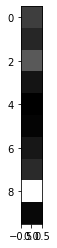

In [6]:
delta = abs(advice.iloc[:,[1]] - real.iloc[:,[1]]) / real.iloc[:,[1]]
delta = delta[:-1]
print('delta')
plt.imshow(delta.values,cmap='gray')

# plot 趨勢圖

In [7]:
def get_actor_action(state,request):
    advice,output,stream = agent.get_advice(state,request)
    return advice[:-1]

In [8]:
def get_real_action(state,request):
    
    #load real data
    state = data['mm_state'].inverse_transform(data['state'])
    action = [data['mm_action'].inverse_transform(i) for i in data['action']]
    output = data['mm_output'].inverse_transform(data['output'])
    stream = data['mm_stream'].inverse_transform(data['stream'])
    
    #calculate distance
    distance_state = (state - set_state)**2
    distance_output = (output - set_request)**2
    min_distance_idx =  np.argmin(distance_state + distance_output)
    
    # show result
    real = pd.DataFrame(action[min_distance_idx],columns=data['action_col'])
    real.loc['mean'] = real.mean(axis=0)
    real.loc['max'] = real.max(axis=0)
    real.loc['min'] = real.min(axis=0)
    real = real.iloc[-3:,:].T
    real['chinese'] = real.index.map(tag_dict)
    real = real[advice.columns]
    return real[:-1]

In [9]:
pred = {}
real = {}
for t in [0,0.25,0.5,0.75]:
    pred[t] = get_actor_action(t,8000)
    real[t] = get_real_action(t,8000)

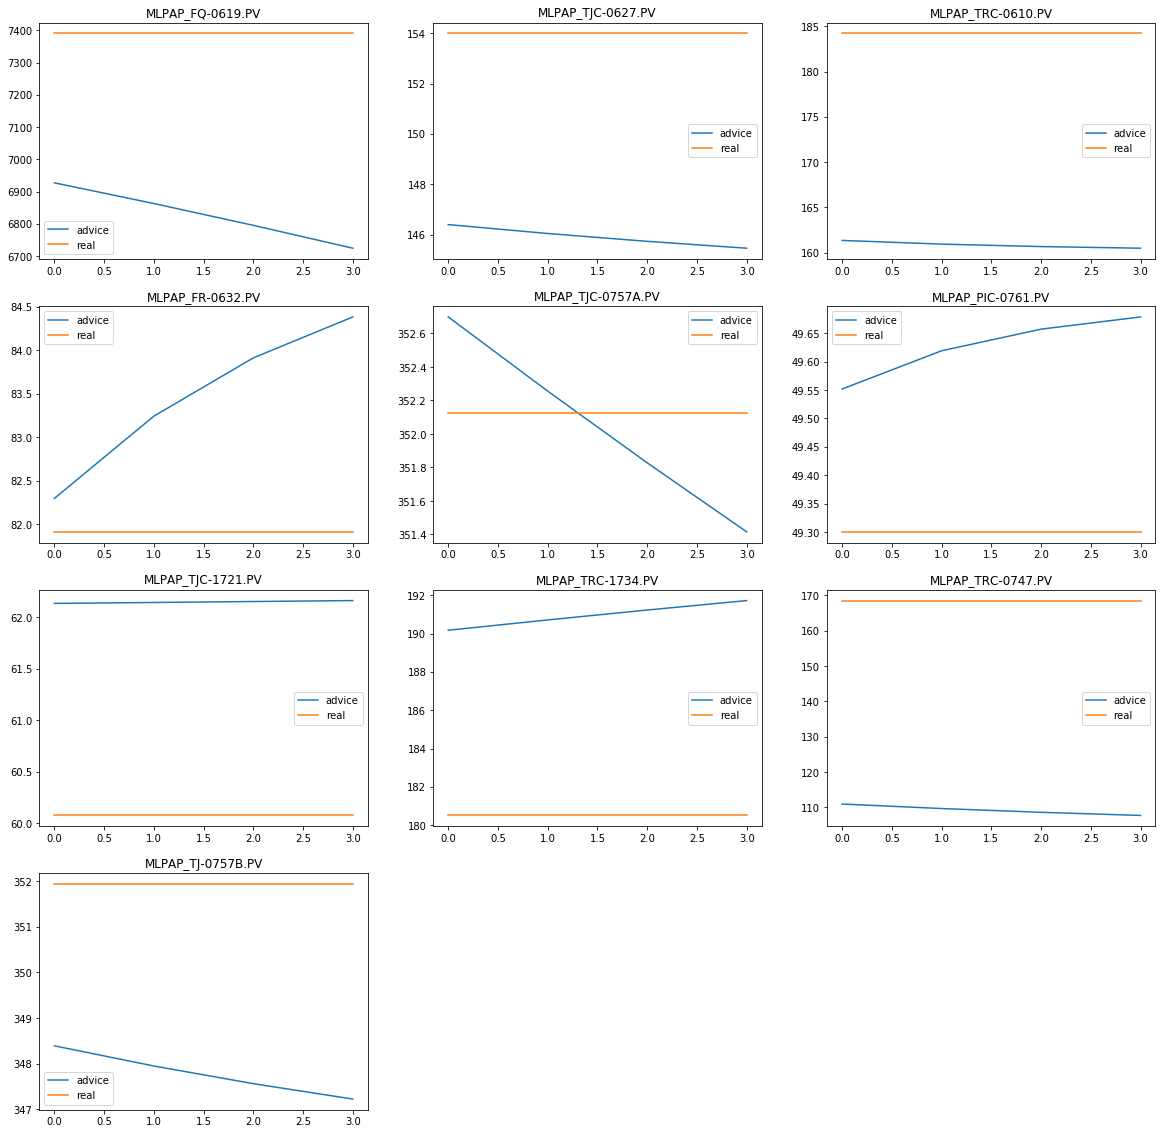

In [10]:
plt.figure(figsize=(20,20))
for idx,y_name in enumerate(data['action_col'][:-1]):
    plt.subplot(4,3,idx+1)
    plt.plot([v.loc[y_name,'mean'] for k,v in pred.items()],label='advice')
    plt.plot([v.loc[y_name,'mean'] for k,v in real.items()],label='real')
    plt.title(y_name)
    plt.legend()
plt.show()